In [128]:
using JuMP
using Gurobi
using DataFrames
using CSV
using LinearAlgebra
using Plots
using Statistics
##### Problem 2 code skeleton

In [4]:
### Solution

# Note: @__DIR__ points to the directory which contains this script file
# Read data
cd(string(@__DIR__, "/Data"))
sessions = convert(Matrix,CSV.File("Pb2_sessions.csv"; header=true) |> DataFrame!);
courses = convert(Matrix,CSV.File("Pb2_courses.csv"; header=true) |> DataFrame!);
rooms = convert(Matrix,CSV.File("Pb2_rooms.csv"; header=true) |> DataFrame!);
preferences = convert(Matrix,CSV.File("Pb2_preferences.csv"; header=true) |> DataFrame!);
cohorts = convert(Matrix,CSV.File("Pb2_cohorts.csv"; header=true) |> DataFrame!);

cd(@__DIR__)

┌ Warning: thread = 1 warning: only found 2 / 3 columns around data row: 31. Filling remaining columns with `missing`
└ @ CSV /Users/leonardboussioux/.julia/packages/CSV/YUbbG/src/file.jl:603


In [34]:
preferences[1,1]

1

In [ ]:
# Initialize sets and parameters
J = size(sessions,1); #number of sessions
C = size(courses,1); #number of courses
R = size(rooms,1); #number of classrooms
S = size(cohorts,1); #number of student cohorts
D = 2; #number of days
T = 6; #number of time blocks
Q = rooms[:,2]; #classroom capacities
U = courses[:,2]; #course units
N = cohorts[:,2]; #number of students per cohort
ms = cohorts[:,3]; #minimum number of units per cohort
Ms = cohorts[:,4]; #maximum number of units per cohort
lambda = 0.1; #preference penalty

mandatory = zeros(S,C); #mandatory courses per cohort
mandatory[1:6,1:5] .= 1;
mandatory[7:13,6:9] .= 1;
mandatory[14:15,10:11] .= 1;
mandatory[16:17,12:13] .= 1;



In [48]:
# Start building model
timelimit = 10*60;
model = Model(Gurobi.Optimizer)
set_optimizer_attribute(model, "TimeLimit", timelimit)

# VARIABLES
@variable(model,z[1:S,1:J,1:D,1:T],Bin);
@variable(model,x[1:J,1:D,1:T,1:R],Bin);

# CONSTRAINTS
@constraint(
    model, [s in 1:S, j in 1:J, d in 1:D, t in 1:T],
    z[s,j,d,t] <= sum(x[j,d,t,r] for r in 1:R)
)

@constraint(
    model,[s in 1:S, d in 1:D, t in 1:T],
    sum(z[s,j,d,t] for j in 1:J) <= 1
)

for c in 1:C
    @constraint(model,
        [s in 1:S],
        sum(z[s,j,d,t]
            for d in 1:D,
                t in 1:T,
                j in sessions[findall(x -> x==c,sessions[:,2]),1])
            <= 1);
end

for s in 1:S
    mandatory_s = findall(x -> x==1,mandatory[s,:]);
    for c in mandatory_s
        @constraint(model,
            sum(z[s,j,d,t]
            for d in 1:D,
                t in 1:T,
                j in sessions[findall(x -> x==c,sessions[:,2]),1])
            >= 1);
    end
end

@constraint(model,[r in 1:R, d in 1:D, t in 1:T],sum(x[j,d,t,r] for j in 1:J) <= 1);

@constraint(model,[j in 1:J],sum(x[j,d,t,r] for r in 1:R, d in 1:D, t in 1:T) == 1);

@constraint(model,[j in 1:J, d in 1:D, t in 1:T],
            sum(N[s]*z[s,j,d,t] for s in 1:S) <= sum(Q[r]*x[j,d,t,r] for r in 1:R))



Academic license - for non-commercial use only - expires 2021-04-27


55×2×6 Array{ConstraintRef{Model,MathOptInterface.ConstraintIndex{MathOptInterface.ScalarAffineFunction{Float64},MathOptInterface.LessThan{Float64}},ScalarShape},3}:
[:, :, 1] =
 60 z[1,1,1,1] + 60 z[2,1,1,1] + 60 z[3,1,1,1] + 60 z[4,1,1,1] + 60 z[5,1,1,1] + 60 z[6,1,1,1] + 10 z[7,1,1,1] + 10 z[8,1,1,1] + 10 z[9,1,1,1] + 10 z[10,1,1,1] + 10 z[11,1,1,1] + 10 z[12,1,1,1] + 10 z[13,1,1,1] + 5 z[14,1,1,1] + 5 z[15,1,1,1] + 10 z[16,1,1,1] + 10 z[17,1,1,1] + 12 z[18,1,1,1] + 12 z[19,1,1,1] + 12 z[20,1,1,1] + 12 z[21,1,1,1] + 12 z[22,1,1,1] + 12 z[23,1,1,1] + 12 z[24,1,1,1] + 12 z[25,1,1,1] + 12 z[26,1,1,1] + 12 z[27,1,1,1] + 12 z[28,1,1,1] + 12 z[29,1,1,1] + 12 z[30,1,1,1] + 12 z[31,1,1,1] + 12 z[32,1,1,1] + 12 z[33,1,1,1] + 12 z[34,1,1,1] + 12 z[35,1,1,1] + 12 z[36,1,1,1] + 12 z[37,1,1,1] + 12 z[38,1,1,1] + 12 z[39,1,1,1] + 12 z[40,1,1,1] + 12 z[41,1,1,1] + 12 z[42,1,1,1] + 12 z[43,1,1,1] + 12 z[44,1,1,1] + 12 z[45,1,1,1] + 12 z[46,1,1,1] + 12 z[47,1,1,1] + 12 z[48,1,1,1] + 12 z[49,1,1,1] +

In [43]:
#Constraint8: at least ms unit
@constraint(model, [s in 1:S],
        sum(sum(U[c]*z[s,j,d,t]
            for d in 1:D,
                t in 1:T,
                j in sessions[findall(x -> x==c,sessions[:,2]),1]
                ) for c in 1:C)
            >= ms[s]);

In [44]:
#Constraint9: at most Ms unit
@constraint(model, [s in 1:S],
        sum(sum(U[c]*z[s,j,d,t]
            for d in 1:D,
                t in 1:T,
                j in sessions[findall(x -> x==c,sessions[:,2]),1]
                ) for c in 1:C)
            <= Ms[s]);

In [49]:
@objective(model, Max, 
    sum(N[s]*z[s,j,d,t]*(preferences[s,c]+lambda*(1-preferences[s,c])) 
        for d in 1:D, 
            t in 1:T, 
            s in 1:S, 
            c in 1:C, 
            j in sessions[findall(x -> x==c,sessions[:,2]),1])
        )

60 z[1,1,1,1] + 60 z[1,2,1,1] + 60 z[1,3,1,1] + 60 z[1,4,1,1] + 60 z[1,5,1,1] + 60 z[1,6,1,1] + 60 z[1,7,1,1] + 60 z[1,8,1,1] + 60 z[1,9,1,1] + 60 z[1,10,1,1] + 60 z[1,11,1,1] + 60 z[1,12,1,1] + 60 z[1,13,1,1] + 60 z[1,14,1,1] + 60 z[1,15,1,1] + 60 z[1,16,1,1] + 60 z[1,17,1,1] + 60 z[1,18,1,1] + 60 z[1,19,1,1] + 60 z[1,20,1,1] + 60 z[1,21,1,1] + 60 z[1,22,1,1] + 60 z[1,23,1,1] + 60 z[1,24,1,1] + 60 z[1,25,1,1] + 60 z[1,26,1,1] + 60 z[1,27,1,1] + 60 z[1,28,1,1] + 60 z[1,29,1,1] + 60 z[1,30,1,1] + 6 z[1,31,1,1] + 6 z[1,32,1,1] + 60 z[1,33,1,1] + 6 z[1,34,1,1] + 6 z[1,35,1,1] + 6 z[1,36,1,1] + 60 z[1,37,1,1] + 60 z[1,38,1,1] + 6 z[1,39,1,1] + 6 z[1,40,1,1] + 6 z[1,41,1,1] + 6 z[1,42,1,1] + 60 z[1,43,1,1] + 60 z[1,44,1,1] + 6 z[1,45,1,1] + 6 z[1,46,1,1] + 6 z[1,47,1,1] + 60 z[1,48,1,1] + 6 z[1,49,1,1] + 6 z[1,50,1,1] + 6 z[1,51,1,1] + 6 z[1,52,1,1] + 6 z[1,53,1,1] + 60 z[1,54,1,1] + 6 z[1,55,1,1] + 60 z[2,1,1,1] + 60 z[2,2,1,1] + 60 z[2,3,1,1] + 60 z[2,4,1,1] + 60 z[2,5,1,1] + 60 z[2,6,1,1

In [46]:
start = time()
optimize!(model)
solvetime = time() - start

Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (mac64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 41149 rows, 50820 columns and 1020312 nonzeros
Model fingerprint: 0x28cd337d
Variable types: 0 continuous, 50820 integer (50820 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [5e-01, 6e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 5e+01]
Presolve removed 1757 rows and 1296 columns
Presolve time: 2.42s
Presolved: 39392 rows, 49524 columns, 971334 nonzeros
Variable types: 0 continuous, 49524 integer (49524 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...


Root simplex log...

Iteration    Objective       Primal Inf.    Dual Inf.      Time
   14015    4.3255384e+03   0.000000e+00   8.980562e+04      5s
   37116    4.8313000e+03   0.000000e+00   0.000000e+00      9s
   37116    4.8313000e+03   0.000000e+00   0.000000e+00      9s
Co

600.6115288734436

In [41]:
objective_value(model)

4746.799999999998

In [47]:
objective_value(model)

4746.799999999997

# Problem 1

In [ ]:
"NOT COMPLETED YET"
"Build shelter location model 1"
function shelter_model_1(distance::Matrix, capacity::Vector, population::Vector)
    # extract problem dimensions from distance matrix and verify coherence of input data
    m, n = size(distance)
    @assert length(capacity) == n
    model = Model(Gurobi.Optimizer)
    set_optimizer_attribute(model, "TimeLimit", 30)
    # VARIABLES
    # Whether to open each shelter
    @variable(model, y[1:n], Bin)
    # Whether to serve a particular area from a particular shelter
    @variable(model, x[1:m, 1:n], Bin)
    # CONSTRAINTS
    @constraint(
        model, serve_every_area[i = 1:m],
        sum(x[i, j] for j = 1:n) == 1
    )
    @constraint(
        model, only_serve_from_open_shelter[i = 1:m, j=1:n],
        x[i, j] <= y[j]
    )
    @constraint(
        model, enough_capacity[j=1:n],
        sum(population[i]*x[i, j] for i=1:m) <= capacity[j]
    )
    @constraint(
        model,
        sum(y[j] for j=1:n) <= 10
    )
    # OBJECTIVE
    @objective(
        model, Min, sum(population[i]*distance[i, j] * x[i, j] for i=1:m, j=1:n)
    )
    
    optimize!(model)
    
    return model, objective_value(model), x, y
end

In [85]:
"Build shelter location model 2"
function shelter_model_2(distance::Matrix, capacity::Vector, population::Vector)
    # extract problem dimensions from distance matrix and verify coherence of input data
    m, n = size(distance)
    @assert length(capacity) == n
    model = Model(Gurobi.Optimizer)
    set_optimizer_attribute(model, "TimeLimit", 30)
    # VARIABLES
    # Whether to open each shelter
    @variable(model, y[1:n], Bin)
    # Whether to serve a particular area from a particular shelter
    @variable(model, x[1:m, 1:n], Bin)
    # CONSTRAINTS
    @constraint(
        model, serve_every_area[i = 1:m],
        sum(x[i, j] for j = 1:n) == 1
    )
    @constraint(
        model, only_serve_from_open_shelter[i = 1:m, j=1:n],
        x[i, j] <= y[j]
    )
    @constraint(
        model, enough_capacity[j=1:n],
        sum(population[i]*x[i, j] for i=1:m) <= capacity[j]
    )
    @constraint(
        model,
        sum(y[j] for j=1:n) == 10
    )
    # OBJECTIVE
    @objective(
        model, Min, sum(population[i]*distance[i, j] * x[i, j] for i=1:m, j=1:n)
    )
    
    optimize!(model)
    
    return model, objective_value(model), x, y
end

shelter_model_2

In [77]:
"Build shelter location model 3"
function shelter_model_3(distance::Matrix, capacity::Vector, population::Vector)
    # extract problem dimensions from distance matrix and verify coherence of input data
    m, n = size(distance)
    @assert length(capacity) == n
    model = Model(Gurobi.Optimizer)
    set_optimizer_attribute(model, "TimeLimit", 30)
    # VARIABLES
    # Whether to open each shelter
    @variable(model, y[1:n], Bin)
    # Whether to serve a particular area from a particular shelter
    @variable(model, x[1:m, 1:n], Bin)
    @variable(model, t>=0)
    # CONSTRAINTS
    @constraint(
        model, serve_every_area[i = 1:m],
        sum(x[i, j] for j = 1:n) == 1
    )
    @constraint(
        model, only_serve_from_open_shelter[i = 1:m, j=1:n],
        x[i, j] <= y[j]
    )
    @constraint(
        model, enough_capacity[j=1:n],
        sum(population[i]*x[i, j] for i=1:m) <= capacity[j]
    )
    @constraint(
        model,
        sum(y[j] for j=1:n) <= 10
    )
    @constraint(
        model, [i=1:m, j=1:n],
        t >= distance[i,j]*x[i,j]
    )
    # OBJECTIVE
    @objective(
        model, Min, t
    )
    
    optimize!(model)
    
    return model, objective_value(model), x, y
end

shelter_model_3

In [117]:
#sessions = convert(Matrix,CSV.File("Pb2_sessions.csv"; header=true) |> DataFrame!);
shelters = convert(Matrix,CSV.File("Pb1_shelters.csv"; header=true) |> DataFrame!);
areas = convert(Matrix,CSV.File("Pb1_areas.csv"; header=true) |> DataFrame!);

#sessions = convert(Matrix,CSV.File("Pb2_sessions.csv"; header=true) |> DataFrame!);
capacities = shelters[:,3];
populations = areas[:,3];
dist = [abs(areas[i, 1] - shelters[j, 1]) + abs(areas[i, 2] - shelters[j, 2]) for i=1:200, j=1:55];
@show size(dist);

size(dist) = (200, 55)


In [118]:
m2, o2, x2, y2 = shelter_model_2(dist, capacities, populations)

Academic license - for non-commercial use only - expires 2021-04-27
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (mac64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 11256 rows, 11055 columns and 44055 nonzeros
Model fingerprint: 0x1d5ac2d5
Variable types: 0 continuous, 11055 integer (11055 binary)
Coefficient statistics:
  Matrix range     [1e+00, 6e+02]
  Objective range  [2e+00, 1e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 2e+04]
Presolve time: 0.06s
Presolved: 11256 rows, 11055 columns, 44055 nonzeros
Variable types: 0 continuous, 11055 integer (11055 binary)
Found heuristic solution: objective 240944.41628

Root relaxation: objective 1.709920e+05, 1925 iterations, 0.11 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 170992.032    0  352 240944.416 170992.032  29.0%     -    0s
H 

(A JuMP Model
Minimization problem with:
Variables: 11055
Objective function type: GenericAffExpr{Float64,VariableRef}
`GenericAffExpr{Float64,VariableRef}`-in-`MathOptInterface.EqualTo{Float64}`: 201 constraints
`GenericAffExpr{Float64,VariableRef}`-in-`MathOptInterface.LessThan{Float64}`: 11055 constraints
`VariableRef`-in-`MathOptInterface.ZeroOne`: 11055 constraints
Model mode: AUTOMATIC
CachingOptimizer state: ATTACHED_OPTIMIZER
Solver name: Gurobi
Names registered in the model: enough_capacity, only_serve_from_open_shelter, serve_every_area, x, y, 171690.6519512599, VariableRef[x[1,1] x[1,2] … x[1,54] x[1,55]; x[2,1] x[2,2] … x[2,54] x[2,55]; … ; x[199,1] x[199,2] … x[199,54] x[199,55]; x[200,1] x[200,2] … x[200,54] x[200,55]], VariableRef[y[1], y[2], y[3], y[4], y[5], y[6], y[7], y[8], y[9], y[10]  …  y[46], y[47], y[48], y[49], y[50], y[51], y[52], y[53], y[54], y[55]])

In [119]:
distances_travelled = []
for i in 1:size(areas)[1]
    for j in 1:size(shelters)[1]
        if value(x2[i,j]) == 1
            append!(distances_travelled, [dist[i,j] for k in 1:convert(Int64, areas[1,3])])
        end
    end
end

In [120]:
maximum(distances_travelled)

5.407430816

In [129]:
mean(distances_travelled)

2.149606546829998

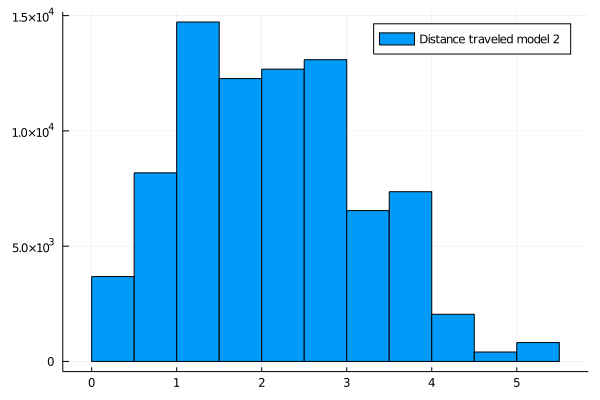

In [121]:
histogram(distances_travelled, label="Distance traveled model 2", bins = 10)

In [122]:
m3, o3, x3, y3 = shelter_model_3(dist, capacities, populations)

Academic license - for non-commercial use only - expires 2021-04-27
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (mac64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 22256 rows, 11056 columns and 66055 nonzeros
Model fingerprint: 0x781d280c
Variable types: 1 continuous, 11055 integer (11055 binary)
Coefficient statistics:
  Matrix range     [5e-03, 6e+02]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 2e+04]
Presolve removed 82 rows and 0 columns
Presolve time: 0.22s
Presolved: 22174 rows, 11056 columns, 65944 nonzeros
Variable types: 1 continuous, 11055 integer (11055 binary)

Root relaxation: objective 4.704182e-01, 4325 iterations, 0.17 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    0.47042    0 2924          -    0.47042      -     -    2s
H    0     0

(A JuMP Model
Minimization problem with:
Variables: 11056
Objective function type: VariableRef
`GenericAffExpr{Float64,VariableRef}`-in-`MathOptInterface.EqualTo{Float64}`: 200 constraints
`GenericAffExpr{Float64,VariableRef}`-in-`MathOptInterface.GreaterThan{Float64}`: 11000 constraints
`GenericAffExpr{Float64,VariableRef}`-in-`MathOptInterface.LessThan{Float64}`: 11056 constraints
`VariableRef`-in-`MathOptInterface.GreaterThan{Float64}`: 1 constraint
`VariableRef`-in-`MathOptInterface.ZeroOne`: 11055 constraints
Model mode: AUTOMATIC
CachingOptimizer state: ATTACHED_OPTIMIZER
Solver name: Gurobi
Names registered in the model: enough_capacity, only_serve_from_open_shelter, serve_every_area, t, x, y, 4.020679578497933, VariableRef[x[1,1] x[1,2] … x[1,54] x[1,55]; x[2,1] x[2,2] … x[2,54] x[2,55]; … ; x[199,1] x[199,2] … x[199,54] x[199,55]; x[200,1] x[200,2] … x[200,54] x[200,55]], VariableRef[y[1], y[2], y[3], y[4], y[5], y[6], y[7], y[8], y[9], y[10]  …  y[46], y[47], y[48], y[49], y[

In [124]:
distances_travelled3 = []
for i in 1:size(areas)[1]
    for j in 1:size(shelters)[1]
        if value(x3[i,j]) == 1
            append!(distances_travelled3, [dist[i,j] for k in 1:convert(Int64, areas[1,3])])
        end
    end
end

In [125]:
maximum(distances_travelled3)

4.020679579

In [130]:
mean(distances_travelled3)

2.523341519504998

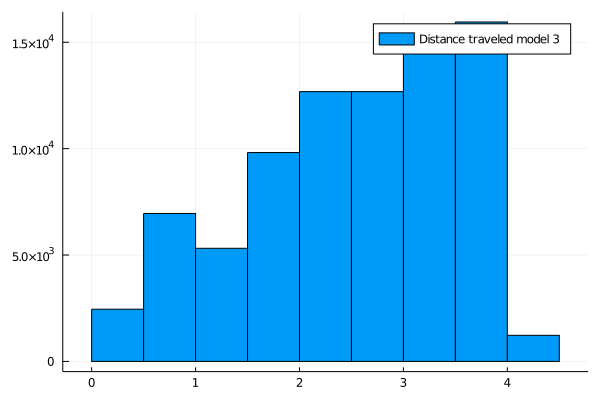

In [126]:
histogram(distances_travelled3, label="Distance traveled model 3", bins = 10)